<span style="font-family:Times New Roman; font-size:1.5em;">**The Utility of Functions**</span>

It's worth refreshing our understanding of functions.  Basically, a function is something that maps the value of an input (e.g., x) to the value of an output (e.g., y).  We can generalize this concept to any sort of process we want to model, which is what makes the basic concept of a function so useful:  if you have a function that accurately describes your system, then you can predict the metric of interest (here, "y") for any value of input that your process takes (here, "x").

You can think of this in terms of all kinds of processes. As a chemical engineer, I might be interested in how much benzene my reactor products as a function of temperature.  Then I know how changing temperature will impact my benzene production.  I also gave the example of BTC price being a function of rainfall in Myanmar.  Once you know how BTC price changes with fluctuations in Burmese precipitation, then you can predict the BTC price by monitoring something physically tangible (rainfall in Myanmar).

You get the idea:  we use functions to build *models* that describe a process of interest.

<span style="font-family:Times New Roman; font-size:1.5em;">**Univariate Functions**</span>

For now, we restrict consideration to univariate functions, which means a function that has only one input variable.  I used y = f(x) for all examples.  Univariate:  I only need the value of x to predict the value of y.

We talk a lot about polynomials, which are functions of variable order, where order is the value of the highest exponent on "x" in your model.  For example:

**Zero order:**

$$y(x) = 5x^0$$

That's zero order because the exponent on x is 0, and $x^0 = 1$.  In practice, we'd never write $x^0$ since we know it is just equal to 1, but it's good to illustrate it here just to make a point that the above is a zero-order polynomial in x.  Typically, you'd just write a zero order polynomial as

$$y(x) = 5$$

Note, if you haven't already installed SpecialMatrices and Polynomials, you'll need to do so. I recommend doing this from the Julia command line.  For SpecialMatrices, it's a little tricky.  Run:

    ]
    add SpecialMatrices
    add SpecialMatrices#master

In [1]:
using Plots
using LinearAlgebra
using Printf
using SpecialMatrices
using Polynomials

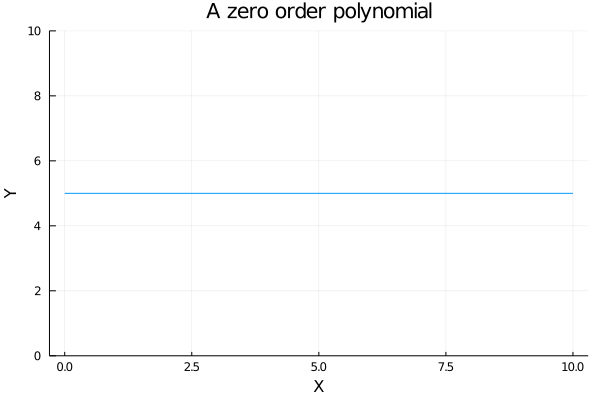

In [2]:
x = 0:1:10
y = zeros(size(x)) .+ 5.0
plt0 = plot(x, y, xlabel = "X", ylabel = "Y", ylim = (0, 10), title = "A zero order polynomial", legend = nothing)

**First order:**

$$y(x) = 5 + 10x$$

You can see that the highest exponent on x here is a 1, so it is a first order polynomial.  When something has a highest order 1, we call that a linear model because, when you graph it, it is a straight line.  This one is familiar to pretty much everyone.  The constant term "5" is called the y-intercept, and the coefficient of $x^1$ (10) is called the slope.

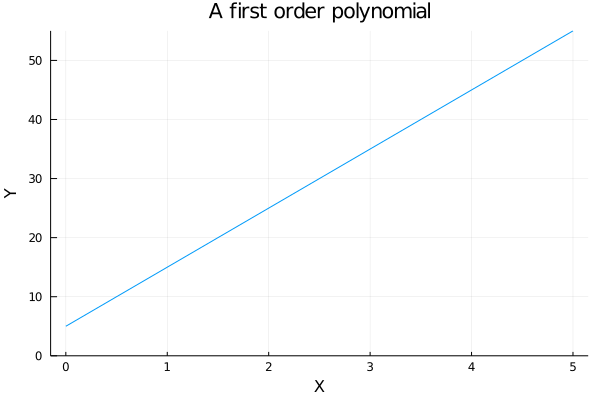

In [3]:
x = 0:0.5:5
y = 5 .+ 10*x
plt1 = plot(x, y, xlabel = "X", ylabel = "Y", ylim = (0, maximum(y)), title = "A first order polynomial", legend = nothing)

**Second order:**

$$y(x) = 5 + 10x + 0.5x^2$$

Here, we have a second order (quadratic) since the leading term has an exponent of 2 on x.  You can see what it looks like below.

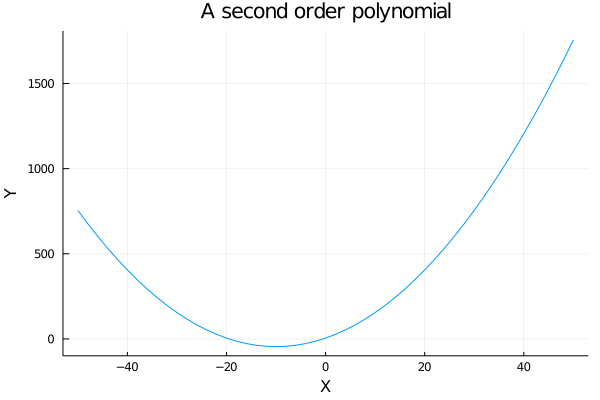

In [4]:
x = -50:2:50
y = 5 .+ 10*x .+ 0.5*x.^2
plt2 = plot(x, y, xlabel = "X", ylabel = "Y", title = "A second order polynomial", legend = nothing)

And so on, we can imagine 3rd, 4th, or a general "nth" order polynomial:

**Third order:**

$$y(x) = 5 + 10x + 0.5x^2 - 0.75x^3$$

**Fourth order:**

$$y(x) = 5 + 10x + 0.5x^2 - 0.75x^3 + 0.035x^4$$

**nth order:**

$$y(x) = 5 + 10x + 0.5x^2 - 0.75x^3 + 0.035x^4 ... + \alpha_{n-1}x^{n-1} + \alpha_{n}x^{n}$$

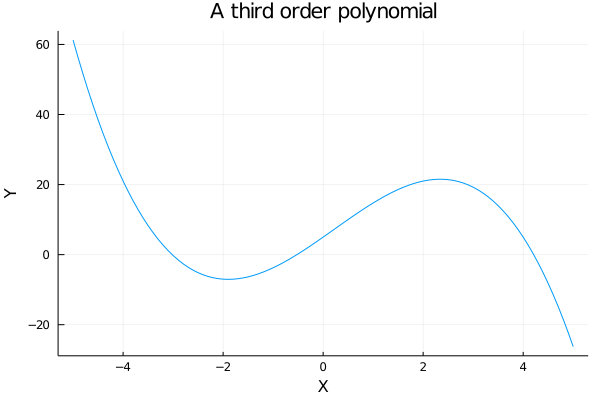

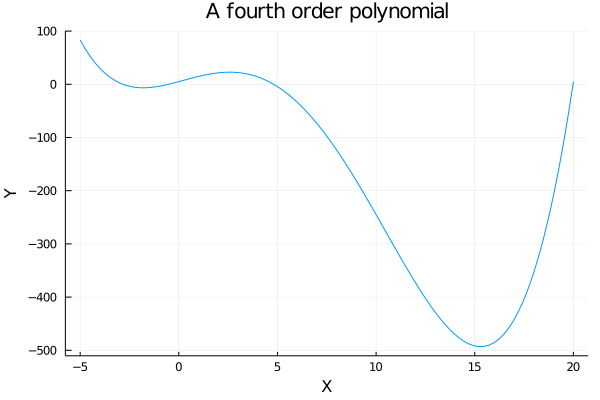

In [5]:
x = -5:0.1:5
y = 5 .+ 10*x .+ 0.5*x.^2 .- 0.75*x.^3
plt3 = plot(x, y, xlabel = "X", ylabel = "Y", title = "A third order polynomial", legend = nothing)

x = range(-5, stop = 20, length = 100)
y = 5 .+ 10*x .+ 0.5*x.^2 .- 0.75*x.^3 .+ 0.035*x.^4;
plt4 = plot(x, y, xlabel = "X", ylabel = "Y", title = "A fourth order polynomial", legend = nothing)

display(plt3)
display(plt4)

<span style="font-family:Times New Roman; font-size:1.5em;">**Data Modelling: An Inverse Problem**</span>

Most of us that analyze data are in the inverse position.  Usually we have measured values of our output (e.g., y or the price of BTC) at various values of our input (e.g., x or rainfall in Myanmar). We would like to have a function (model) that tells us explicitly how our output (BTC price) changes as a function of our input (Burmese rainfall), but we don't know that function - we have to build the model by analyzing the data.  That is the core of the inverse problem.

We should briefly consider the difference between interpolation and extrapolation.  Interpolation would be inferring the value of an output for a value of input that lies *between* measurements you have already made, whereas extrapolation would be forecasting the value of an output at a value of input that lies *outside* of the range that you've measured.  In general, interpolation is safer than extrapolation, but you can see why the ability to extrapolate to input values that you haven't measured would be useful: 

"Wow, it has never rained 145 inches in Burma in a day before!  I wonder what this will do to the price of BTC?"

Loosely, we'll look at two possible approaches to developing a model from data.  The first is to construct an "interpolating polynomial," which we'll define loosely as a function that passes through each data point of interest exactly.  The second is a "regression polynomial," which is a function that models the line of best fit through all data of interest.  By "best fit," we mean the model that gives the least possible error between measurement and prediction.

Regardless of the approach, I've found it most intuitive to start by framing this problem using systems of equations, which form a good foundation for the more complicated topics in model fitting and parameter estimation.

**Converting data into a system of equations**

The basic idea here is that you have available to you, either through your own measurement or through mining some sort of database, a value of an output (anything you're interested in, e.g., price of BTC) measured at one or more values of an input (anything that you suspect will influence the value of your output, e.g., rainfall in Myanmar). 

For now, we'll keep it simple:  we have an output of interest called "y" and an input of interest called "x".  In familiar terms, these would be the dependent variable (y) and independent variable (x). So, the minimum size set of data we will look at here is 2 measurements.  If you have one measurement (say y = 5 when x = 7), the only prediction you can make from it is that y = 5 when x = 7. Once you get to two measurements, you can start to build models, for reasons that I think become more clear when you look at how this is done.

So here, we have two (x,y) measurements. Specifically, when x = 1, y = 4...and when x = 2, y = 7.  More concisely, these are (x,y) pairs: (1,4) and (2,7).

Let's put those on a graph:

In [1]:
x = [1, 2]
y = [4, 7]
plt5 = scatter(x, y, xlim = (0, 3), ylim = (0, 10), xlabel = "X", ylabel = "Y", legend = nothing)

LoadError: UndefVarError: scatter not defined

Looking at the data now, you can intuit something fundamental about data fitting.  It is very clear that if you want to put a straight line (linear) through those points, there is exactly one line that will pass through both points.  If, on the other hand, you want to put a curved line through them...well...there could be an infinite number of quadratics, cubics, etc. that will pass exactly through both points.

There is a really nice mathematical reason for this: if we use this data to construct a system of equations, it is fully determined, and it has a unique solution. Specifically, let's combine our measured values with our knowledge of a linear function, namely that the general equation for a line expressed with an unknown slope (m) and an unknown y-intercept (b) is given by 

$$y(x) = mx+b$$

With that equation in mind, realize that we have two (x,y) pairs from which to construct a system of equations.  Substituting those values, we get the following two equations:

\begin{align}
    4 = 1m+b\\
    7 = 2m+b\\
\end{align}

Ah!  A system of equations!  This looks like an algebra problem!! The nature of the inverse problem reveals itself here -- you know the values of the independent and dependent variables, but you do not know the coefficients in the polynomial that describe the line.  So, the core of your inverse problem is to find those coefficients.  Fortunately, here, you have 2 equations, written in 2 unknowns (m and b).  It's fully determined, and there is one and only one solution:

\begin{align}
    m = 3\\
    b = 1\\
\end{align}

If we overlay our data on that line, we'll find that it passes through both points exactly.

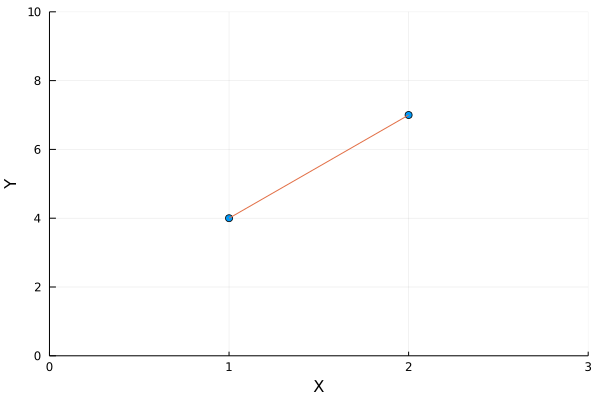

In [7]:
x = [1;2];
y = [4;7];
m = 3;
b = 1;
xline = [1; 2];
yline(x) = @.(m*x + b);
plt5 = plot!(plt5, xline, yline(xline))

This is the basic concept of an "interpolating polynomial."  We have constructed a function that passes through each point exactly, and you'll notice again that if we do this for two points, then there is one and only one line that passes exactly through the pair.

If instead I tried to fit a zero order polynomial to my data (i.e, $y = C$, where C is a constant):

\begin{align}
    4 = C\\
    7 = C\\
\end{align}

You see that this is impossible - there is no constant, at least in normal mathematics, that simultaneously equals 4 and 7. That is to say, you need at least a first order polynomial to be able to pass through both data points.

In contrast, if I were to try to fit a second order polynomial here, where the general expression for a 2nd order polynomial is:

$$y(x) = \alpha_0 + \alpha_1x + \alpha_2x^2$$

You would find that you generate the following system of equations by substituting in the (x,y) pairs we measured:

\begin{align}
    4 = \alpha_0 + 1\alpha_1 + 1\alpha_2\\
    7 = \alpha_0 + 2\alpha_1 + 4\alpha_2\\
\end{align}

No good -- there are 2 equations written in 3 unknowns ($\alpha_0$, $\alpha_1$, and $\alpha_2$).  This system is underdetermined (not enough constraints), and we can find an infinite number of ($\alpha_0$, $\alpha_1$, $\alpha_2$) sets that will create 2nd order polynomials that pass exactly through each point.

So the corollary to the above statement about a 0 order polynomial is that there are (I think) an infinite number of 2nd order polynomials that will describe this data because it is an underdetermined system.

In data fitting, these ideas generalize to larger and larger data sets.  The general concept is that, when given $n+1$ data points, you can fit an $n_{th}$ order polynomial that passes exactly through those $n+1$ data points.  If your polynomial is lower order than $n$, the system is overdetermined (too many constraints), and you can't find a unique solution.  If your polynomial is higher order than $n$, the system is underdetermined (too few constraints), and you can't find a unique solution.  

**A Quadratic Example**

For a concrete illustration of that concept--that you can find a unique, $n^{th}$ order polynomial to pass exactly through $n+1$ data points, let's consider the scenario where you make 3 (x,y) measurements:  (1,8), (2,4), and (3,6).  That's 3 data points, so we can find a unique, 2nd order (quadratic) polynomial that goes through each data point.

First, it's always helpful to plot the data:

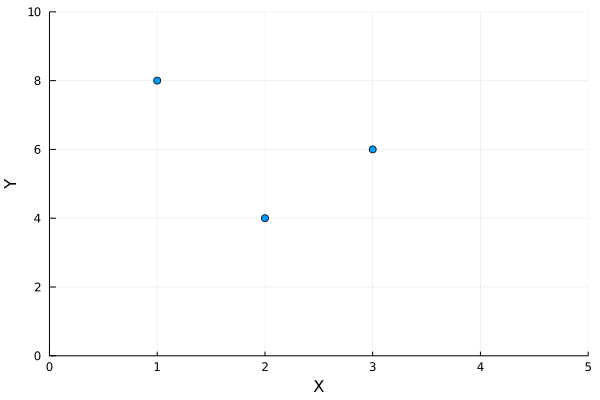

In [8]:
x = [1, 2, 3]
y = [8, 4, 6]
plt6 = scatter(x, y, xlim = (0, 5), ylim = (0, 10), xlabel = "X", ylabel = "Y", legend = nothing)

Now you can see that you need some curvature to pass through those 3 data points--a straight line won't do it.  Start in the same place:  use the data to make a system of equations using the generic model for a 2nd order polynomial, i.e., $y(x) = \alpha_0 + \alpha_1x + \alpha_2x^2$.  Substituting (x,y) pairs into this model gives:

\begin{align}
    8 = \alpha_0 + 1\alpha_1 + 1\alpha_2\\
    4 = \alpha_0 + 2\alpha_1 + 4\alpha_2\\
    6 = \alpha_0 + 3\alpha_1 + 9\alpha_2\\
\end{align}

And there you see why you get to find a unique 2nd order polynomial.  The system of equations is fully determined--there are 3 equations, and 3 unknowns ($\alpha_0$, $\alpha_1$, $\alpha_2$), so there is a unique set of ($\alpha_0$, $\alpha_1$, $\alpha_2$) values that define this data set.

You find them by algebraic solution of the system to get:

\begin{align}
    \alpha_0 &= 18\\
    \alpha_1 &= -13\\
    \alpha_2 &= 3\\
\end{align}

And below, we'll overlay that polynomial with our original data set.  You'll see that the line passes exactly through each data point.

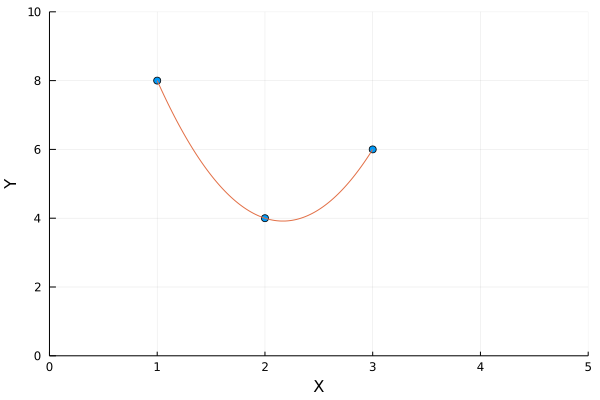

In [9]:
xline = range(1, stop = 3, length = 100)
alpha0 = 18;
alpha1 = -13;
alpha2 = 3;
yline(x) = @. (alpha0 + alpha1*x + alpha2*x^2);
plt6 = plot!(plt6, xline, yline(xline), xlim = (0, 5), ylim = (0, 10), xlabel = "X", ylabel = "Y", legend = nothing)

Again, reinforcing those general concepts, I can't find a straight line that will pass through all three ($n+1$) data points...and I can probably find infinite cubics (third order polynomials) that will pass through all data.  Only the quadratic ($n^{th}$ order)is "just right" because the system is fully determined.

These are super useful concepts, and the easiest way to generalize them to higher order systems (and minimize the tedium in solving algebraic equations on your part) is to take advantage of linear algebra.

**A Matrix/Vector representation of the Inverse Problem**

Going back to our linear problem, where we had two (x,y) pairs, (1,4) and (2,7), that we wanted to describe with a linear model $y(x) = mx+b$. In doing so, we wrote the following two equations.

\begin{align}
    4 = 1m+b\\
    7 = 2m+b\\
\end{align}

To support abstraction to higher order polynomials, I'm going to replace the coefficients in that linear polynomial (m and b) with $\alpha_i$ values.  The $\alpha$ is just a constant-valued coefficient, and the subscript $i$ represents the degree of x that particular $\alpha$ is multiplied by in the polynomial.  

\begin{align}
    4 = 1\alpha_1 + \alpha_0\\
    7 = 2\alpha_1 + \alpha_0\\
\end{align}

I'm also going to put it in the form that I typically see with this type of problem.  This is just a rearrangement.

\begin{align}
    1\alpha_0 + 1\alpha_1 = 4\\
    1\alpha_0 + 2\alpha_1 = 7\\
\end{align}

Now I see this is just a system of equations that are all linear with respect to the coefficients, i.e., all of the $\alpha$'s have an exponent of 1.  Realizing that, I can re-write this in Matrix/Vector notation:

$$\begin{bmatrix} 1 & 1 \\ 1 & 2 \\ \end{bmatrix} \times 
\begin{bmatrix} \alpha_0 \\ \alpha_1 \end{bmatrix} = 
\begin{bmatrix} 4 \\ 7 \end{bmatrix}$$

Just a refresher:  this is matrix multiplication.  In matrix multiplication, you multiply each element in a row by each element in the column and sum their values.

Breaking down these terms, you see that the matrix on the left corresponds to the value of x that is multiplied by each value of $\alpha$.  Note that $\alpha_0$ multiplies by $x^0$, but we usually just call that 1 since we know its value already.  In the first row, we have values of $x_1$, which is the x in our first (x,y) pair (1,4).  In the second row, we have values of $x_2$, which is the x in our second (x,y) pair (2,7). 

If we multiply these x values by the coefficients as shown above, it gives us the values of $y_1$ in the first row and $y_2$ in the second row.

$$\begin{bmatrix} x_1^0 & x_1^1 \\ x_2^0 & x_2^1 \\ \end{bmatrix} \times 
\begin{bmatrix} \alpha_0 \\ \alpha_1 \end{bmatrix} = 
\begin{bmatrix} y_1 \\ y_2 \end{bmatrix}$$

Usually, you'll see this matrix equation in the shorthand:

$$XA = Y$$

Where X is a matrix of input values, A is a vector of coefficients that specify the polynomial you're trying to fit, and Y is a vector of your measured output values at each corresponding value of your input (X).  Since we have measured values of X and Y, then A contains all of the unknowns (coefficients) in this system.

This is where we leverage linear algebra to do the heavy lifting of solving for an interpolating polynomial.  If this were a standard algebraic equation, we'd solve for A as:

$$A = Y/X$$

or, more relevant here:

$$A = X^{-1}Y$$

Matrices behave a little differently.  Instead of the first, more intuitive division operator, we want to take a Matrix Inverse here.  I like to visualize this as multiplying both sides of our equation by the inverse of the X matrix in steps.  So with a linear algebra solution, I'd solve this problem with the following steps:

\begin{align}
    XA &= Y\\
    X^{-1}XA &= X^{-1}Y\\
    IA &= X^{-1}Y\\
    A &= X^{-1}Y\\
\end{align}

This is the Matrix equivalent of dividing through by X.  If you're unfamiliar with I, this is the identity matrix, which is the Matrix equivalent of the number 1.  When I multiply I by a matrix or Vector, it returns the value of that Matrix or Vector unchanged, so I drop the I in the final line.  Formally:

$$IA = \begin{bmatrix} 1 & 0 \\ 0 & 1 \\ \end{bmatrix} \times 
\begin{bmatrix} \alpha_0 \\ \alpha_1 \\ \end{bmatrix} = 
\begin{bmatrix} \alpha_0 \\ \alpha_1 \\ \end{bmatrix} = 
A$$

So, we'll put this into practice in the cell below, where I'll create an X matrix and a Y vector, and then solve for A using a matrix inversion.  You see we get the exact same values of $\alpha_0$ (intercept) and $\alpha_1$ (slope) that we got above.  It's just a much more succinct solution.  Note that instead of using full matrix inversion as noted above, it is generally more efficient to use the left divide operator:

$$A = X \ \backslash \ Y$$

In [10]:
X = [1 1; 1 2]
Y = [4, 7]
A = X\Y
yintercept = A[1]
slope = A[2]
display(X)
display(Y)
display(A)
@printf("The slope is %0.1f and the y-intercept is %0.1f.", slope, yintercept)

2×2 Array{Int64,2}:
 1  1
 1  2

2-element Array{Int64,1}:
 4
 7

2-element Array{Float64,1}:
 1.0
 3.0

The slope is 3.0 and the y-intercept is 1.0.

This really becomes much more useful when we got to higher order polynomials, where the algebra becomes more cumbersome.  So let's apply to our second order example.  Recall, we're trying to fit a quadratic ($n_{th}$ order) to 3 data points ($n+1$ data points): (1,8), (2,4), and (3,6)

Above, we used that to generate this system of equations:

\begin{align}
    8 = \alpha_0 + 1\alpha_1 + 1\alpha_2\\
    4 = \alpha_0 + 2\alpha_1 + 4\alpha_2\\
    6 = \alpha_0 + 3\alpha_1 + 9\alpha_2\\
\end{align}

Which we can then put into the matrix form we developed in the previous cell:

\begin{align}
    \alpha_0 + 1\alpha_1 + 1\alpha_2 = 8\\
    \alpha_0 + 2\alpha_1 + 4\alpha_2 = 4\\
    \alpha_0 + 3\alpha_1 + 9\alpha_2 = 6\\
\end{align}

And then:

$$\begin{bmatrix} 1 & 1 & 1 \\ 1 & 2 & 4 \\ 1 & 3 & 9 \end{bmatrix} \times 
\begin{bmatrix} \alpha_0 \\ \alpha_1 \\ \alpha_2 \\ \end{bmatrix} = 
\begin{bmatrix} 8 \\ 4 \\ 6 \\ \end{bmatrix}$$

Which is just numbers plugged into the general form:

$$\begin{bmatrix} x_1^0 & x_1^1 & x_1^2 \\ x_2^0 & x_2^1 & x_2^2 \\ x_3^0 & x_3^1 & x_3^2 \\ \end{bmatrix} \times 
\begin{bmatrix} \alpha_0 \\ \alpha_1 \\ \alpha_2 \\ \end{bmatrix} = 
\begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ \end{bmatrix}$$

And so, we again arrive at:

$$XA = Y$$

Which we can solve by matrix inversion for all unknown coefficients, which we recall should be (-18, 13, 3)

The key to this idea is that, although our models are nonlinear in X, all of our X values are known.  We are solving for coefficients, and the equations above are always linear in the coefficients, so we can use matrix methods.

In [11]:
X = [1 1 1; 1 2 4; 1 3 9]
Y = [8, 4, 6]
A = X\Y
display(X)
display(Y)
display(A)

3×3 Array{Int64,2}:
 1  1  1
 1  2  4
 1  3  9

3-element Array{Int64,1}:
 8
 4
 6

3-element Array{Float64,1}:
  18.0
 -13.0
   3.0

This is awesome because it is a **completely** general concept.  You can construct any model to match your data points in this way, and you can use the matrix inversion to solve for the uknown coefficients.  I can do this for any $n_{th}$ order polynomial I wish:

$$\begin{bmatrix} x_1^0 & x_1^1 & x_1^2 & x_1^3 & \cdots & x_1^{n-1} & x_1^{n} \\ x_2^0 & x_2^1 & x_2^2 & x_2^3 & \cdots & x_2^{n-1} & x_2^{n} \\ x_3^0 & x_3^1 & x_3^2 & x_3^3 & \cdots & x_3^{n-1} & x_3^{n} \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\ x_{n}^0 & x_{n}^1 & x_{n}^2 & x_{n}^3 & \cdots & x_{n}^{n-1} & x_{n}^{n} \\ x_{n+1}^0 & x_{n+1}^1 & x_{n+1}^2 & x_{n+1}^3 & \cdots & x_{n+1}^{n-1} & x_{n+1}^{n} \end{bmatrix} \times 
\begin{bmatrix} \alpha_0 \\ \alpha_1 \\ \alpha_2 \\ \alpha_3 \\ \vdots \\ \alpha_{n-1} \\ \alpha_{n} \\ \end{bmatrix} = 
\begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ \vdots \\ y_{n} \\ y_{n+1} \end{bmatrix}$$

It looks complicated, but realize that it is an expression for a generic, $n^{th}$ order polynomial fit to $n+1$ (x,y) pairs.

And again: no matter how nonlinear my model is in ***X***, we are solving the inverse problem of trying to find coefficients from known values of X and Y.  The problem is always linear in the coefficients, so we can use matrix methods.

The most tedious part of these problems is generating the X matrix from your input values. It is not too bad if you have good support for vectorized operations in your programming language.  For example, let's say we want to fit a 10th order polynomial to 11 (x,y) pairs that I'm going to generate randomly.  I'll just walk through the way you'd construct the X matrix and Y vector from this data.  Once you do that, it's just a matrix inversion as usual.

In [12]:
xdata = rand(11,)
ydata = rand(11,)

11-element Array{Float64,1}:
 0.8507027638391862
 0.1901098240067618
 0.9955426120900901
 0.2904893778608739
 0.3170671537859677
 0.029714867791646782
 0.0019175894701937146
 0.4242198233760057
 0.8025943757709062
 0.610877220257587
 0.39006338166811205

Now we'll go ahead and plot this mess:

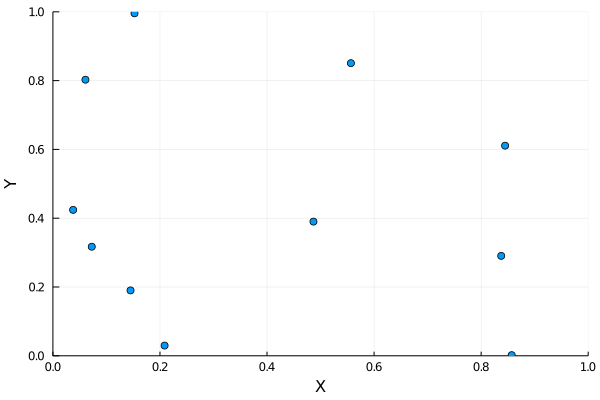

In [13]:
plt7 = scatter(xdata, ydata, xlim = (0, 1), ylim = (0, 1), xlabel = "X", ylabel = "Y", legend = nothing)

As we expect, I can find one unique 10th order polynomial to fit my 11 data points exactly, so let's create that X matrix to represent this.

In [14]:
X = ones(11,11);
X[:,2]  = xdata;
X[:,3]  = xdata.^2;
X[:,4]  = xdata.^3;
X[:,5]  = xdata.^4;
X[:,6]  = xdata.^5;
X[:,7]  = xdata.^6;
X[:,8]  = xdata.^7;
X[:,9]  = xdata.^8;
X[:,10] = xdata.^9;
X[:,11] = xdata.^10;
X

11×11 Array{Float64,2}:
 1.0  0.556735   0.309954    0.172562     …  0.00513848   0.00286077
 1.0  0.145028   0.021033    0.00305037      2.83829e-8   4.1163e-9
 1.0  0.15245    0.023241    0.0035431       4.44785e-8   6.78075e-9
 1.0  0.837511   0.701425    0.587452        0.202729     0.169788
 1.0  0.0726016  0.00527099  0.000382682     5.6042e-11   4.06874e-12
 1.0  0.208668   0.0435421   0.00908583   …  7.50056e-7   1.56512e-7
 1.0  0.857047   0.73453     0.629527        0.249485     0.21382
 1.0  0.0378052  0.00142923  5.40324e-5      1.57747e-13  5.96366e-15
 1.0  0.0608013  0.0036968   0.000224771     1.13558e-11  6.9045e-13
 1.0  0.8448     0.713687    0.602922        0.219172     0.185156
 1.0  0.486768   0.236944    0.115337     …  0.00153427   0.000746835

The corresponding Y vetor is easy:

In [15]:
Y = ydata

11-element Array{Float64,1}:
 0.8507027638391862
 0.1901098240067618
 0.9955426120900901
 0.2904893778608739
 0.3170671537859677
 0.029714867791646782
 0.0019175894701937146
 0.4242198233760057
 0.8025943757709062
 0.610877220257587
 0.39006338166811205

Now, solve for A using the matrix inversion.

In [16]:
A = X\Y

11-element Array{Float64,1}:
      13.708962641341145
   -1293.1637408825477
   46965.39801164828
 -821688.6995988496
       7.672099383203478e6
      -4.066154944296415e7
       1.2678718622563416e8
      -2.3607979943042937e8
       2.57522601035839e8
      -1.516312845081319e8
       3.7184059174558304e7

Now, let's use those coefficients to create a polynomial of 10th order that can accept vector arguments.  I'll pass a 100 element set of x values to create a smooth line between x = 0 and x = 1.  You'll see it hits all of our data points exactly.  No comment yet as to what it does between those points.

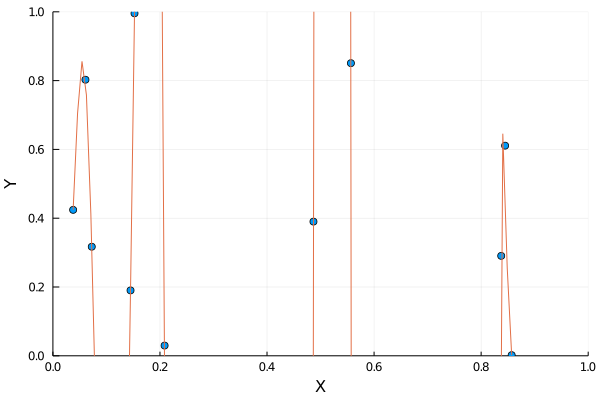

In [17]:
yline(x) = @. (A[1] + A[2]*x + A[3]*x.^2 + A[4]*x.^3 + A[5]*x.^4 + A[6]*x.^5 + A[7]*x.^6 + A[8]*x.^7 + A[9]*x.^8 + A[10]*x.^9 + A[11]*x.^10);
xline = range(minimum(xdata), stop = maximum(xdata), length = 100);
plt7 = plot!(plt7, xline, yline(xline))

Now, let's plot this on a larger x and y axis...

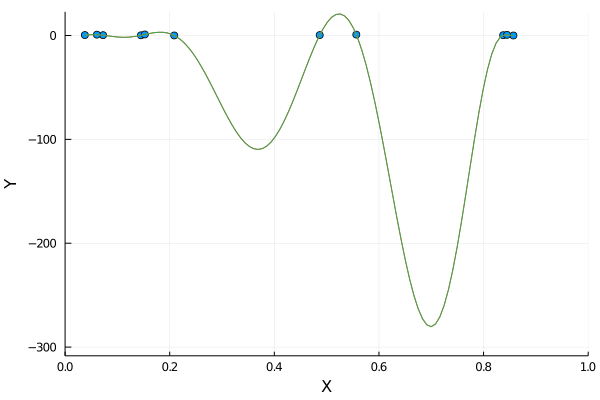

In [18]:
ymodel = yline(xline)
plt8 = scatter(xdata, ydata, xlabel = "X", ylabel = "Y", legend = nothing)
plt8 = plot!(plt7, xline, ymodel, xlim = (0, 1), ylim = (minimum(ymodel)*1.1, maximum(ymodel)*1.1))

So you can see...while a 10th order polynomial nails our data points...it does so with excessive "wiggle" in order to caputure the extreme nonlinearity required to pass through all data points. Although you *can* put a 10th order polynomial through 11 data points...it isn't necessarily a great idea because, chances are, if your data are all restricted to the range [0,1], it is pretty questionable whether y has values so far outside of [0,1] in this range.  It gets even worse if you try to extrapolate outside of the range where you fit things:

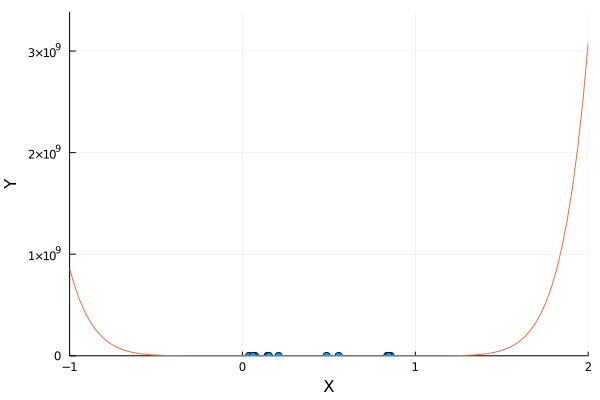

In [19]:
xline = range(-1, stop = 2, length = 100)
ymodel = yline(xline)
plt9 = scatter(xdata, ydata, xlabel = "X", ylabel = "Y", legend = nothing)
plt9 = plot!(plt9, xline, ymodel, xlim = (minimum(xline), maximum(xline)), ylim = (minimum(ymodel)*1.1, maximum(ymodel)*1.1))

High order polynomials rapidly approach +/- infinity as you go outside of the fit range.  So, again, although this "interpolating polynomial" passes through all of our data, it isn't very useful in a predictive sense for either interpolation or extrapolation.  More typically, when we have large data sets, we won't fit a max order polynomial to them.  We will try to find a good model that describes the data without overfitting, as we've done here.

This pretty much wraps up the first exercise on interpolating polynomials, but a few bookkeeping notes before closing:

The "X" matrix for an $n^{th}$ order polynomial is called the Vandermonde matrix.  It is so common, that most programming languages will have a function that generates it automatically from a data set.  In Julia, it's Vandermonde(); using it will require you to add the SpecialMatrices.jl package.

Note: you don't really need to use SpecialMatrices or the Vandermonde matrix in this course.  If you want to use it, I suggest going to the julia command line and running:

    ]
    add SpecialMatrices
    add SpecialMatrices#master


In [20]:
Xauto = Vandermonde(xdata)

11×11 Vandermonde{Float64}:
 1.0  0.556735   0.309954    0.172562     …  0.00513848   0.00286077
 1.0  0.145028   0.021033    0.00305037      2.83829e-8   4.1163e-9
 1.0  0.15245    0.023241    0.0035431       4.44785e-8   6.78075e-9
 1.0  0.837511   0.701425    0.587452        0.202729     0.169788
 1.0  0.0726016  0.00527099  0.000382682     5.6042e-11   4.06874e-12
 1.0  0.208668   0.0435421   0.00908583   …  7.50056e-7   1.56512e-7
 1.0  0.857047   0.73453     0.629527        0.249485     0.21382
 1.0  0.0378052  0.00142923  5.40324e-5      1.57747e-13  5.96366e-15
 1.0  0.0608013  0.0036968   0.000224771     1.13558e-11  6.9045e-13
 1.0  0.8448     0.713687    0.602922        0.219172     0.185156
 1.0  0.486768   0.236944    0.115337     …  0.00153427   0.000746835

In [21]:
#This can be used just as we did above to find the coefficients.

Xauto\ydata

11-element Array{Float64,1}:
      13.70896274873129
   -1293.1637492008167
   46965.39826429014
 -821688.7034901805
       7.672099416685037e6
      -4.066154961163588e7
       1.267871867358859e8
      -2.3607980036425582e8
       2.5752260204545033e8
      -1.5163128510059583e8
       3.718405931990202e7

Further, because polynomial fitting is so common, most languages include a function that automates data fitting without going through the linear algebra hoops.  In Julia, it's called fit(); it is in the Polynomials.jl package. Construct identical polynomials to what we did above (also equivalent to something like trendline in Excel).

In [22]:
x1 = [1, 2]
x2 = [1, 2, 3]
x10 = xdata
y1 = [4, 7]
y2 = [8, 4, 6]
y10 = ydata;
p1 = fit(x1,y1,1) 
p2 = fit(x2,y2,2)
p3 = fit(x10,y10,10)

display(p1)
display(p2)
display(p3)

Polynomial(1.0 + 3.0*x)

Polynomial(18.0 - 13.0*x + 3.0*x^2)

Polynomial(13.70896274873129 - 1293.1637492008167*x + 46965.39826429014*x^2 - 821688.7034901805*x^3 + 7.672099416685037e6*x^4 - 4.066154961163588e7*x^5 + 1.267871867358859e8*x^6 - 2.3607980036425582e8*x^7 + 2.5752260204545033e8*x^8 - 1.5163128510059583e8*x^9 + 3.718405931990202e7*x^10)

We can use any of these polynomials to evaluate our y values for any set of x values.  For example:

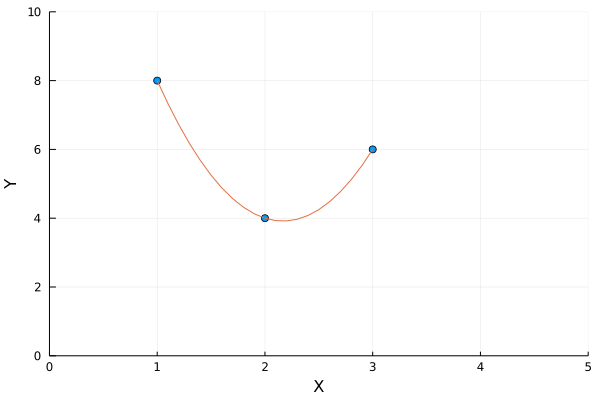

In [23]:
x2 = [1, 2, 3]
y2 = [8, 4, 6]
xmodel = 1:0.1:3
ymodel = p2.(xmodel)
plt10 = scatter(x2, y2, xlim = (0, 5), ylim = (0, 10), xlabel = "X", ylabel = "Y", legend = nothing)
plt10 = plot!(plt10, xmodel, ymodel)

Finally, there is no reason we have to restrict ourselves to a conventional definition of a polynomial as a function with increasing powers of "x."  You can create any sort of polynomial that will describe your data and convert it into an analog of the Vandermonde Matrix that describes your system.  For example, let's just say I had a set of data that was described by this goofball function:

$$y(x) = \alpha_ax^3 + \alpha_b\ln(x) + \alpha_c\cos(x)$$

If I have 3 (x,y) pairs, i can solve for the three coefficients using the exact same approach I did above, i.e., this isn't restricted to typical "polynomial" functions of x.  This is a key foundational concept for things like multiple linear regression and machine learning tools like neural networks.

$$\begin{bmatrix} x_1^3 & \ln(x_1) & \cos(x_1) \\ x_2^3 & \ln(x_2) & \cos(x_2) \\ x_3^3 & \ln(x_3) & \cos(x_3) \\ \end{bmatrix} \times 
\begin{bmatrix} \alpha_a \\ \alpha_b \\ \alpha_c \\ \end{bmatrix} = 
\begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ \end{bmatrix}$$

Just as a demonstration, we'll generate 3 y values for x = [1;2;3] using this function with coefficient values of ($\alpha_a$, $\alpha_b$, $\alpha_c$) = (3, 7, 19)

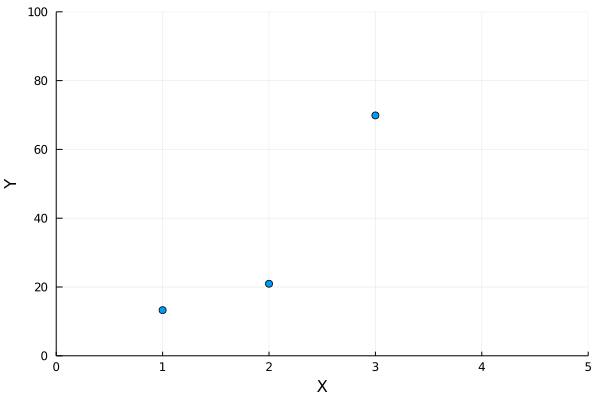

In [24]:
func(x) = @. (3*x^3 + 7*log(x) + 19*cos(x));
xvals = [1, 2, 3]
yvals = func(xvals)
plt11 = scatter(xvals, yvals, xlim = (0, 5), ylim = (0, 100), xlabel = "X", ylabel = "Y", legend = nothing)

Now solve for the coefficients:

In [25]:
X = zeros(3,3);
X[:,1] = xvals.^3;
X[:,2] = log.(xvals);
X[:,3] = cos.(xvals);
display(X)
Y = yvals
A = X\Y

3×3 Array{Float64,2}:
  1.0  0.0        0.540302
  8.0  0.693147  -0.416147
 27.0  1.09861   -0.989992

3-element Array{Float64,1}:
  3.0
  7.0
 18.999999999999996

And, as usual, you can use those coefficients to generate a polynomial that describes your data on the domain you have collected it.

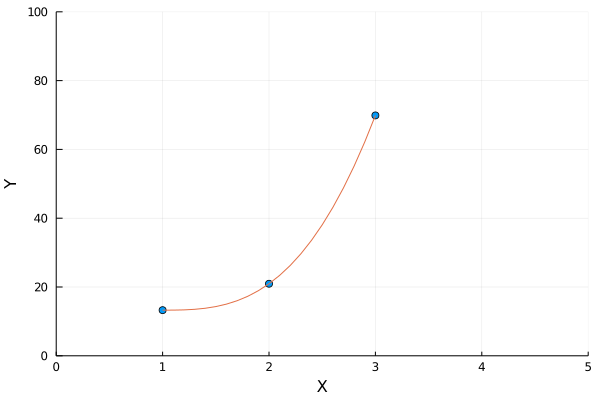

In [26]:
yfunc(x) = @. A[1]*x^3 + A[2]*log(x) + A[3]*cos(x)
xmodel    = 1:0.1:3
ymodel    = yfunc(xmodel)
plt11     = plot!(plt11, xmodel, ymodel)